In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt 
import numpy as np
from tqdm import tqdm
import sklearn as sk

# Task 1 - Load the MNIST Dataset

Here I just load the mnist dataset and provide a quick look at a sample

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
X shape: (55000, 784)
Y shape: (55000, 10)



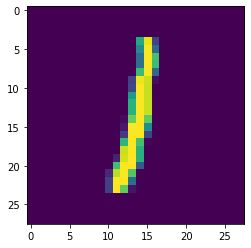

In [4]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)
# print out shapes and example im
print("X shape: {}".format(mnist.train.images.shape))
print("Y shape: {}".format(mnist.train.labels.shape))
n = 28
n_classes = 10
print()
plt.imshow(mnist.train.images[4].reshape(28,28))

# Task 2 - Define weights and bias

Here I define the weights for my CNN model (defined below). I have the weights for four 2D convolutional layers and two fully connected layers

In [5]:
W = {'W_0': tf.get_variable('W0', shape=(3,3,1,16), initializer=tf.contrib.layers.xavier_initializer()),
       'W_1': tf.get_variable('W1', shape=(3,3,16,64), initializer=tf.contrib.layers.xavier_initializer()),
       'W_2': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()),
       'W_3': tf.get_variable('W3', shape=(3,3,128,256), initializer=tf.contrib.layers.xavier_initializer()),
       'W_4': tf.get_variable('W4', shape=(256 * 2 * 2,128), initializer=tf.contrib.layers.xavier_initializer()),
       'W_5': tf.get_variable('W5', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()),
      }
b = {'B_0': tf.get_variable('B0', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
       'B_1': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
       'B_2': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
       'B_3': tf.get_variable('B3', shape=(256), initializer=tf.contrib.layers.xavier_initializer()),
       'B_4': tf.get_variable('B4', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
       'B_5': tf.get_variable('B5', shape=(n_classes), initializer=tf.contrib.layers.xavier_initializer()),
      }

Instructions for updating:
Colocations handled automatically by placer.


# Task 3 - Start Tensorflow interactive session

In [6]:
sess = tf.InteractiveSession()

# Task 4 - Build a function to train the model

Here I define a function to train a model via softmax cross entropy. I also have parameterized batch size, learning rate (for Adam optim) and number of epochs 

In [7]:
def trainModel(Model,X,Y,lr = 0.001,batch_sz = 128,num_epochs = 100,model_pth = './model.ckpt'):
    if len(X.shape) < 4: 
        X = X.reshape(-1, 28, 28, 1)
    x = tf.placeholder("float", [None, n,n,1])
    y = tf.placeholder("float", [None, n_classes])
    
    pred = Model(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    
    num_correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(num_correct, tf.float32))
    saver = tf.train.Saver()
    train_loss = []
    train_accuracy = []
    init = tf.global_variables_initializer()
    
    batchLen = len(X) // batch_sz
    init = tf.initialize_all_variables()
    sess.run(init)
    for i in tqdm(range(num_epochs)):
        for j in range(batchLen):
            batch_X = X[j*batch_sz:min((j+1)*batch_sz,len(X))]
            batch_Y = Y[j*batch_sz:min((j+1)*batch_sz,len(Y))]

            opt = sess.run(optimizer, feed_dict={x: batch_X,y: batch_Y})
            loss,acc = sess.run([cost, accuracy], feed_dict={x: batch_X,y: batch_Y})
        train_loss.append(loss)
        train_accuracy.append(acc)
        print("Epoch: {}, Loss: {}, Accuracy: {}".format(i + 1,loss,acc))
        save_path = saver.save(sess, model_pth)
    plt.figure()
    plt.plot(train_loss,'r--',linewidth=2)
    plt.title("train loss per epoch")
    
    plt.figure()
    plt.plot(train_accuracy,'g',linewidth=2)
    plt.title("train accuracy per epoch")

# Task 5 - Build a function to test the model

Here I define a function to test the model on a holdout test set. I report:

accuracy: ( TP + TN /(TOTAL))

recall: (TP/(TP + FN))

precision: (TP/(TP + FP))

f1 score: (2 * precision * recall / (precision + recall))

as my metrics. 

(Note. These values are averaged across all 10 classes and reported as a singular value)



In [8]:
def testModel(Model,test_X,test_Y,model_pth = "./model.ckpt"):
    if len(test_X.shape) < 4: 
        test_X = test_X.reshape(-1, 28, 28, 1)
    x = tf.placeholder("float", [None, n,n,1])
    y = tf.placeholder("float", [None, n_classes])
    pred = Model(x)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    num_correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    
    accuracy = tf.reduce_mean(tf.cast(num_correct, tf.float32))
    y_hat = tf.argmax(pred,1)
    
    saver = tf.train.Saver()

    test_loss,test_acc,predicted_y = sess.run([cost,accuracy,y_hat], feed_dict={x: test_X,y : test_Y})
    y_gt = np.argmax(test_Y,1)
    
    precision = sk.metrics.precision_score(y_gt, predicted_y,average='micro')
    recall = sk.metrics.recall_score(y_gt, predicted_y,average='micro')
    f1 = sk.metrics.f1_score(y_gt, predicted_y,average='micro')
    
    saver.restore(sess, model_pth)
    print("test loss: {}".format(test_loss))
    print("test accuracy: {}".format(test_acc))
    print ("avg precision across classes : {}".format(precision))
    print ("avg recall across classes: {}".format(recall))
    print ("avg f1_score across classes: {}".format(f1))
    return test_loss,test_acc,precision,recall,f1

# Task 6 - Build a function for convolution layer

Below I define my CNN architecture. I use four (conv2d - leaky-relu - maxpool) layers and then two fully connected layers to get the output of the model into the shape of number of classes (10,1)

In [9]:
class CNN(object):
    def __init__(self,W,b):
        self.W = W
        self.b = b
    def conv(self,x,W_i,b_i,s = 1):
        x = tf.nn.bias_add(tf.nn.conv2d(x, W_i,[1,s,s,1],padding='SAME'),b_i)
        return tf.nn.leaky_relu(x)
    def maxpool(self,x):
        kernel_sz= [1,2,2,1]
        return tf.nn.max_pool(x,kernel_sz,kernel_sz,padding='SAME')
    def dense(self,x,W_i,b_i):
        return tf.nn.leaky_relu(tf.add(tf.matmul(x,W_i),b_i))
    def __call__(self,x):
        c0 = self.conv(x, self.W['W_0'], self.b['B_0']) # 28 x 28 x 16
        m0 = self.maxpool(c0)
        
        c1 = self.conv(m0,self.W['W_1'],self.b['B_1']) # 14 x 14 x 64
        m1 = self.maxpool(c1)
        
        c2 = self.conv(m1,self.W['W_2'],self.b['B_2']) # 7 x 7 x 128
        m2 = self.maxpool(c2)
        
        c3 = self.conv(m2,self.W['W_3'],self.b['B_3']) # 4 x 4 x 256
        m3 = self.maxpool(c3) # 2 x 2 x 256

        d0 = tf.reshape(m3, [-1, self.W['W_4'].get_shape().as_list()[0]]) # (256 x 2 x 2, 1)
        d0 = self.dense(d0,self.W['W_4'], self.b['B_4']) # (128, 1)

        d1 = self.dense(d0,self.W['W_5'],self.b['B_5']) # (10,1)
        return d1 
model = CNN(W,b)

# Task 7 Evaluate the model and provide accuracy for classification

The two cells below train the model and then evaluate it using the train and test set for mnist respectively. As stated before, I report the accuracy, avg. precision, avg. recall and  avg. f1 score. Emperically, I've found all of these metrics to be above 0.99 on the test set.

 10%|█         | 1/10 [00:47<07:07, 47.48s/it]

Epoch: 1, Loss: 0.005176599603146315, Accuracy: 1.0


 20%|██        | 2/10 [01:35<06:21, 47.74s/it]

Epoch: 2, Loss: 0.011341002769768238, Accuracy: 0.9921875


 30%|███       | 3/10 [02:25<05:38, 48.42s/it]

Epoch: 3, Loss: 0.004639945924282074, Accuracy: 1.0


 40%|████      | 4/10 [03:14<04:51, 48.57s/it]

Epoch: 4, Loss: 0.0018130172975361347, Accuracy: 1.0


 50%|█████     | 5/10 [04:02<04:01, 48.35s/it]

Epoch: 5, Loss: 0.009981744922697544, Accuracy: 0.9921875


 60%|██████    | 6/10 [04:56<03:19, 49.93s/it]

Epoch: 6, Loss: 0.0006363600841723382, Accuracy: 1.0


 70%|███████   | 7/10 [05:51<02:34, 51.47s/it]

Epoch: 7, Loss: 0.0002566226467024535, Accuracy: 1.0


 80%|████████  | 8/10 [06:46<01:45, 52.58s/it]

Epoch: 8, Loss: 7.687827746849507e-05, Accuracy: 1.0


 90%|█████████ | 9/10 [07:41<00:53, 53.32s/it]

Epoch: 9, Loss: 2.9559208996943198e-05, Accuracy: 1.0


100%|██████████| 10/10 [08:37<00:00, 51.71s/it]

Epoch: 10, Loss: 0.0008096302626654506, Accuracy: 1.0


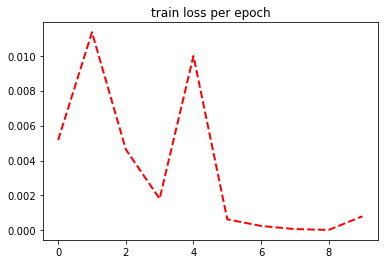

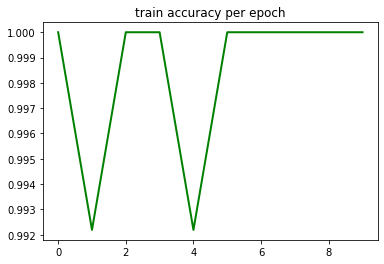

In [11]:
trainModel(model,mnist.train.images,mnist.train.labels,num_epochs = 10)

In [13]:
testModel(model,mnist.test.images,mnist.test.labels)

INFO:tensorflow:Restoring parameters from ./model.ckpt
test loss: 0.03642547130584717
test accuracy: 0.9904000163078308
avg precision across classes : 0.9904
avg recall across classes: 0.9904
avg f1_score across classes: 0.9904


(0.03642547, 0.9904, 0.9904, 0.9904, 0.9904)